# Nuclei Segmentation by NB(Nuclei Boundary) model

## Initial Setup

In [1]:
import os
import shutil
import glob
import random
import cv2
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from model import *

# GPU use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

Using TensorFlow backend.


## Show dataset example
This sample dataset contains 128 and 32 images for training and validation, respectively. The amount of data in this dataset alone is most likely not enough for deep learning.

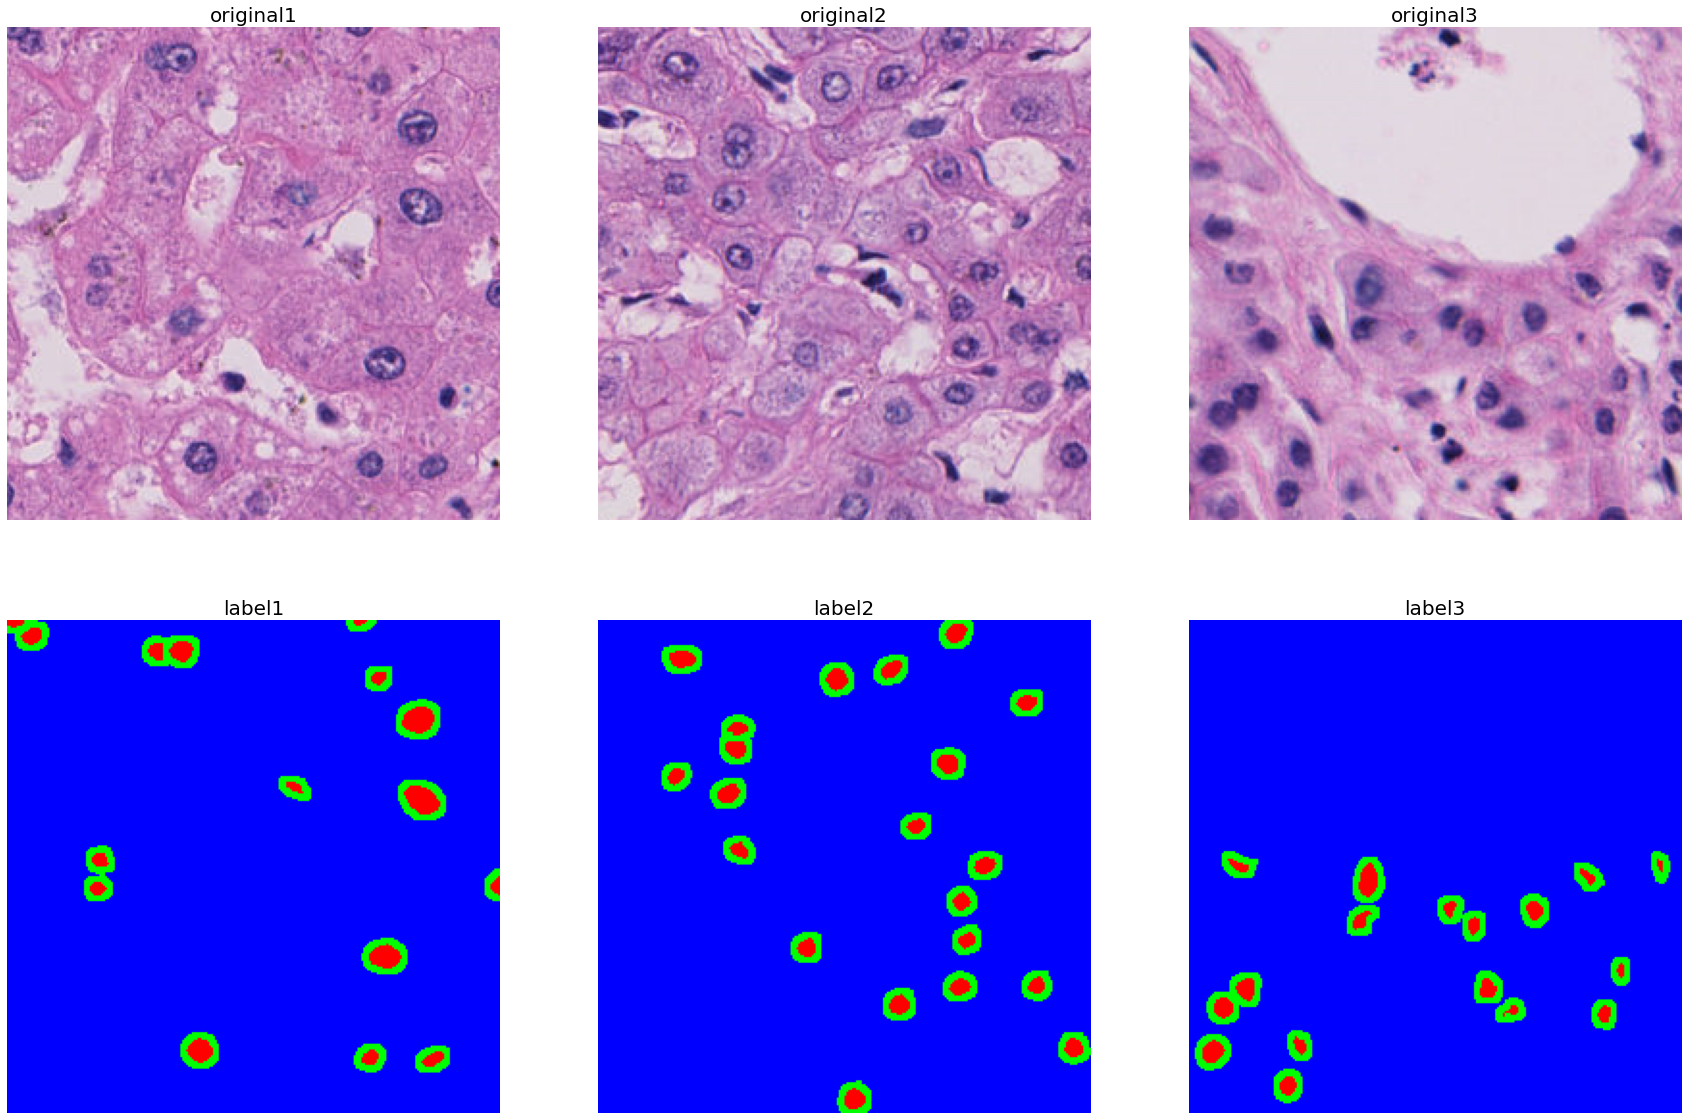

In [2]:
image_list = sorted(glob.glob("sample/train/image/*"))
label_list = sorted(glob.glob("sample/train/label/*"))

fig, axs = plt.subplots(2, 3, figsize=(30,20))
sampling = random.sample(range(len(image_list)), k=3)
for col, i in enumerate(sampling):
    img = cv2.imread(image_list[i])
    label = cv2.imread(label_list[i])
    axs[0, col].set_title("original{}".format(col+1), fontsize=20)
    axs[0, col].axis("off")
    axs[0, col].imshow(img[:,:,::-1])
    axs[1, col].set_title("label{}".format(col+1), fontsize=20)
    axs[1, col].axis("off")
    axs[1, col].imshow(label[:,:,::-1])

## Configuration

In [3]:
INPUT_SHAPE = (256, 256, 3)
DATASET_DIR = "sample"
BATCH_SIZE = 4
EPOCHS = 100

In [4]:
def ImageGenerator(batch_size, data_dir, image_folder, mask_folder, aug_dict,
                   image_color_mode = "rgb", mask_color_mode = "rgb",
                   target_size = (256, 256), seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        data_dir,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        data_dir,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img = img/255
        mask = mask/255
        yield img, mask
        
def testGenerator(test_list):
    for test_path in test_list:
        img = cv2.imread(test_path)
        img = img[:,:,::-1] / 255
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [5]:
model = unet_mish(input_size = INPUT_SHAPE)
model.compile(optimizer =  keras.optimizers.Adam(lr = 1e-5), 
              loss="categorical_crossentropy",
              metrics = ["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [6]:
data_gen_args = dict(horizontal_flip = True,
                    vertical_flip = True,
                    rotation_range = 20,
                    zoom_range = [0.95, 1.05],
                    width_shift_range = 0.1,
                    height_shift_range = 0.1,
                    fill_mode = "constant",
                    cval = 0)
val_gen_args = dict(horizontal_flip = False,
                    vertical_flip = False)

# generator of training data and validation data
trainGene = ImageGenerator(batch_size = BATCH_SIZE,
                        data_dir = DATASET_DIR + '/train',
                        image_folder = "image",
                        mask_folder = "label",
                        target_size = INPUT_SHAPE[:2],
                        aug_dict = data_gen_args)
valGene = ImageGenerator(batch_size = BATCH_SIZE,
                        data_dir = DATASET_DIR + '/val',
                        image_folder = "image",
                        mask_folder = "label",
                        target_size = INPUT_SHAPE[:2],
                        aug_dict = val_gen_args)

In [7]:
steps_per_epoch = len(glob.glob(DATASET_DIR + "/train/image/*"))//BATCH_SIZE
validation_steps = len(glob.glob(DATASET_DIR + "/val/image/*"))//BATCH_SIZE
model_checkpoint = ModelCheckpoint('unet_mish.h5', 
                            monitor='loss',
                            verbose=1, 
                            save_best_only=True)
history = model.fit_generator(trainGene, 
                            validation_data=valGene,  
                            epochs=EPOCHS,
                            steps_per_epoch=steps_per_epoch, 
                            validation_steps=validation_steps,
                            callbacks=[model_checkpoint])

Epoch 1/100
Found 32 images belonging to 1 classes.
Found 128 images belonging to 1 classes.
Found 128 images belonging to 1 classes.
Found 32 images belonging to 1 classes.
32/32 [==============================] - 23s 713ms/step - loss: 0.8761 - accuracy: 0.5789 - val_loss: 0.9132 - val_accuracy: 0.8432

Epoch 00001: loss improved from inf to 0.87610, saving model to unet_mish.h5
Epoch 2/100
 1/32 [..............................] - ETA: 5s - loss: 0.8069 - accuracy: 0.6714

/home/adachi/anaconda3/envs/demo/lib/python3.6/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


32/32 [==============================] - 7s 207ms/step - loss: 0.7563 - accuracy: 0.7190 - val_loss: 0.8492 - val_accuracy: 0.8964

Epoch 00002: loss improved from 0.87610 to 0.75626, saving model to unet_mish.h5
Epoch 3/100
32/32 [==============================] - 7s 207ms/step - loss: 0.6757 - accuracy: 0.7944 - val_loss: 0.7082 - val_accuracy: 0.9402

Epoch 00003: loss improved from 0.75626 to 0.67571, saving model to unet_mish.h5
Epoch 4/100
32/32 [==============================] - 7s 207ms/step - loss: 0.6046 - accuracy: 0.8391 - val_loss: 0.5992 - val_accuracy: 0.9481

Epoch 00004: loss improved from 0.67571 to 0.60457, saving model to unet_mish.h5
Epoch 5/100
32/32 [==============================] - 7s 206ms/step - loss: 0.5445 - accuracy: 0.8627 - val_loss: 0.5516 - val_accuracy: 0.9503

Epoch 00005: loss improved from 0.60457 to 0.54451, saving model to unet_mish.h5
Epoch 6/100
32/32 [==============================] - 7s 207ms/step - loss: 0.4943 - accuracy: 0.8758 - val_loss:

32/32 [==============================] - 7s 207ms/step - loss: 0.2092 - accuracy: 0.8584 - val_loss: 0.2126 - val_accuracy: 0.9741

Epoch 00039: loss did not improve from 0.20799
Epoch 40/100
32/32 [==============================] - 7s 206ms/step - loss: 0.2079 - accuracy: 0.8548 - val_loss: 0.2291 - val_accuracy: 0.9735

Epoch 00040: loss improved from 0.20799 to 0.20792, saving model to unet_mish.h5
Epoch 41/100
32/32 [==============================] - 7s 207ms/step - loss: 0.1991 - accuracy: 0.8558 - val_loss: 0.2194 - val_accuracy: 0.9734

Epoch 00041: loss improved from 0.20792 to 0.19912, saving model to unet_mish.h5
Epoch 42/100
32/32 [==============================] - 7s 207ms/step - loss: 0.1959 - accuracy: 0.8523 - val_loss: 0.2129 - val_accuracy: 0.9753

Epoch 00042: loss improved from 0.19912 to 0.19586, saving model to unet_mish.h5
Epoch 43/100
32/32 [==============================] - 7s 207ms/step - loss: 0.1974 - accuracy: 0.8527 - val_loss: 0.2428 - val_accuracy: 0.9726

32/32 [==============================] - 7s 207ms/step - loss: 0.1521 - accuracy: 0.8562 - val_loss: 0.1713 - val_accuracy: 0.9769

Epoch 00078: loss did not improve from 0.15177
Epoch 79/100
32/32 [==============================] - 7s 207ms/step - loss: 0.1555 - accuracy: 0.8623 - val_loss: 0.1682 - val_accuracy: 0.9757

Epoch 00079: loss did not improve from 0.15177
Epoch 80/100
32/32 [==============================] - 7s 207ms/step - loss: 0.1509 - accuracy: 0.8565 - val_loss: 0.1536 - val_accuracy: 0.9776

Epoch 00080: loss improved from 0.15177 to 0.15094, saving model to unet_mish.h5
Epoch 81/100
32/32 [==============================] - 7s 207ms/step - loss: 0.1552 - accuracy: 0.8638 - val_loss: 0.1510 - val_accuracy: 0.9766

Epoch 00081: loss did not improve from 0.15094
Epoch 82/100
32/32 [==============================] - 7s 207ms/step - loss: 0.1509 - accuracy: 0.8604 - val_loss: 0.1646 - val_accuracy: 0.9757

Epoch 00082: loss improved from 0.15094 to 0.15086, saving model t

In [8]:
model.load_weights("unet_mish.h5")
        
test_image_list = sorted(glob.glob("sample/val/image/*"))
test_label_list = sorted(glob.glob("sample/val/label/*"))
test_steps = len(test_image_list)

testGene = testGenerator(test_image_list)
pred = model.predict_generator(testGene, steps=test_steps, verbose=1)

if os.path.exists("sample/predict"):
    shutil.rmtree("sample/predict")
if not os.path.exists("sample/predict"):
    os.makedirs("sample/predict")

COLOR_DICT = [(255,0,0), (0,255,0), (0,0,255)]
for img_path, img_pred in zip(test_image_list, pred):
    img = np.zeros(INPUT_SHAPE, dtype=np.uint8)
    pre = np.argmax(img_pred, axis=2)
    for j in range(len(COLOR_DICT)):
        img[pre==j]=COLOR_DICT[j]
    cv2.imwrite("sample/predict/{}".format(img_path.split("/")[-1]),img[:,:,::-1])

32/32 [==============================] - 3s 100ms/step


## Show prediction example

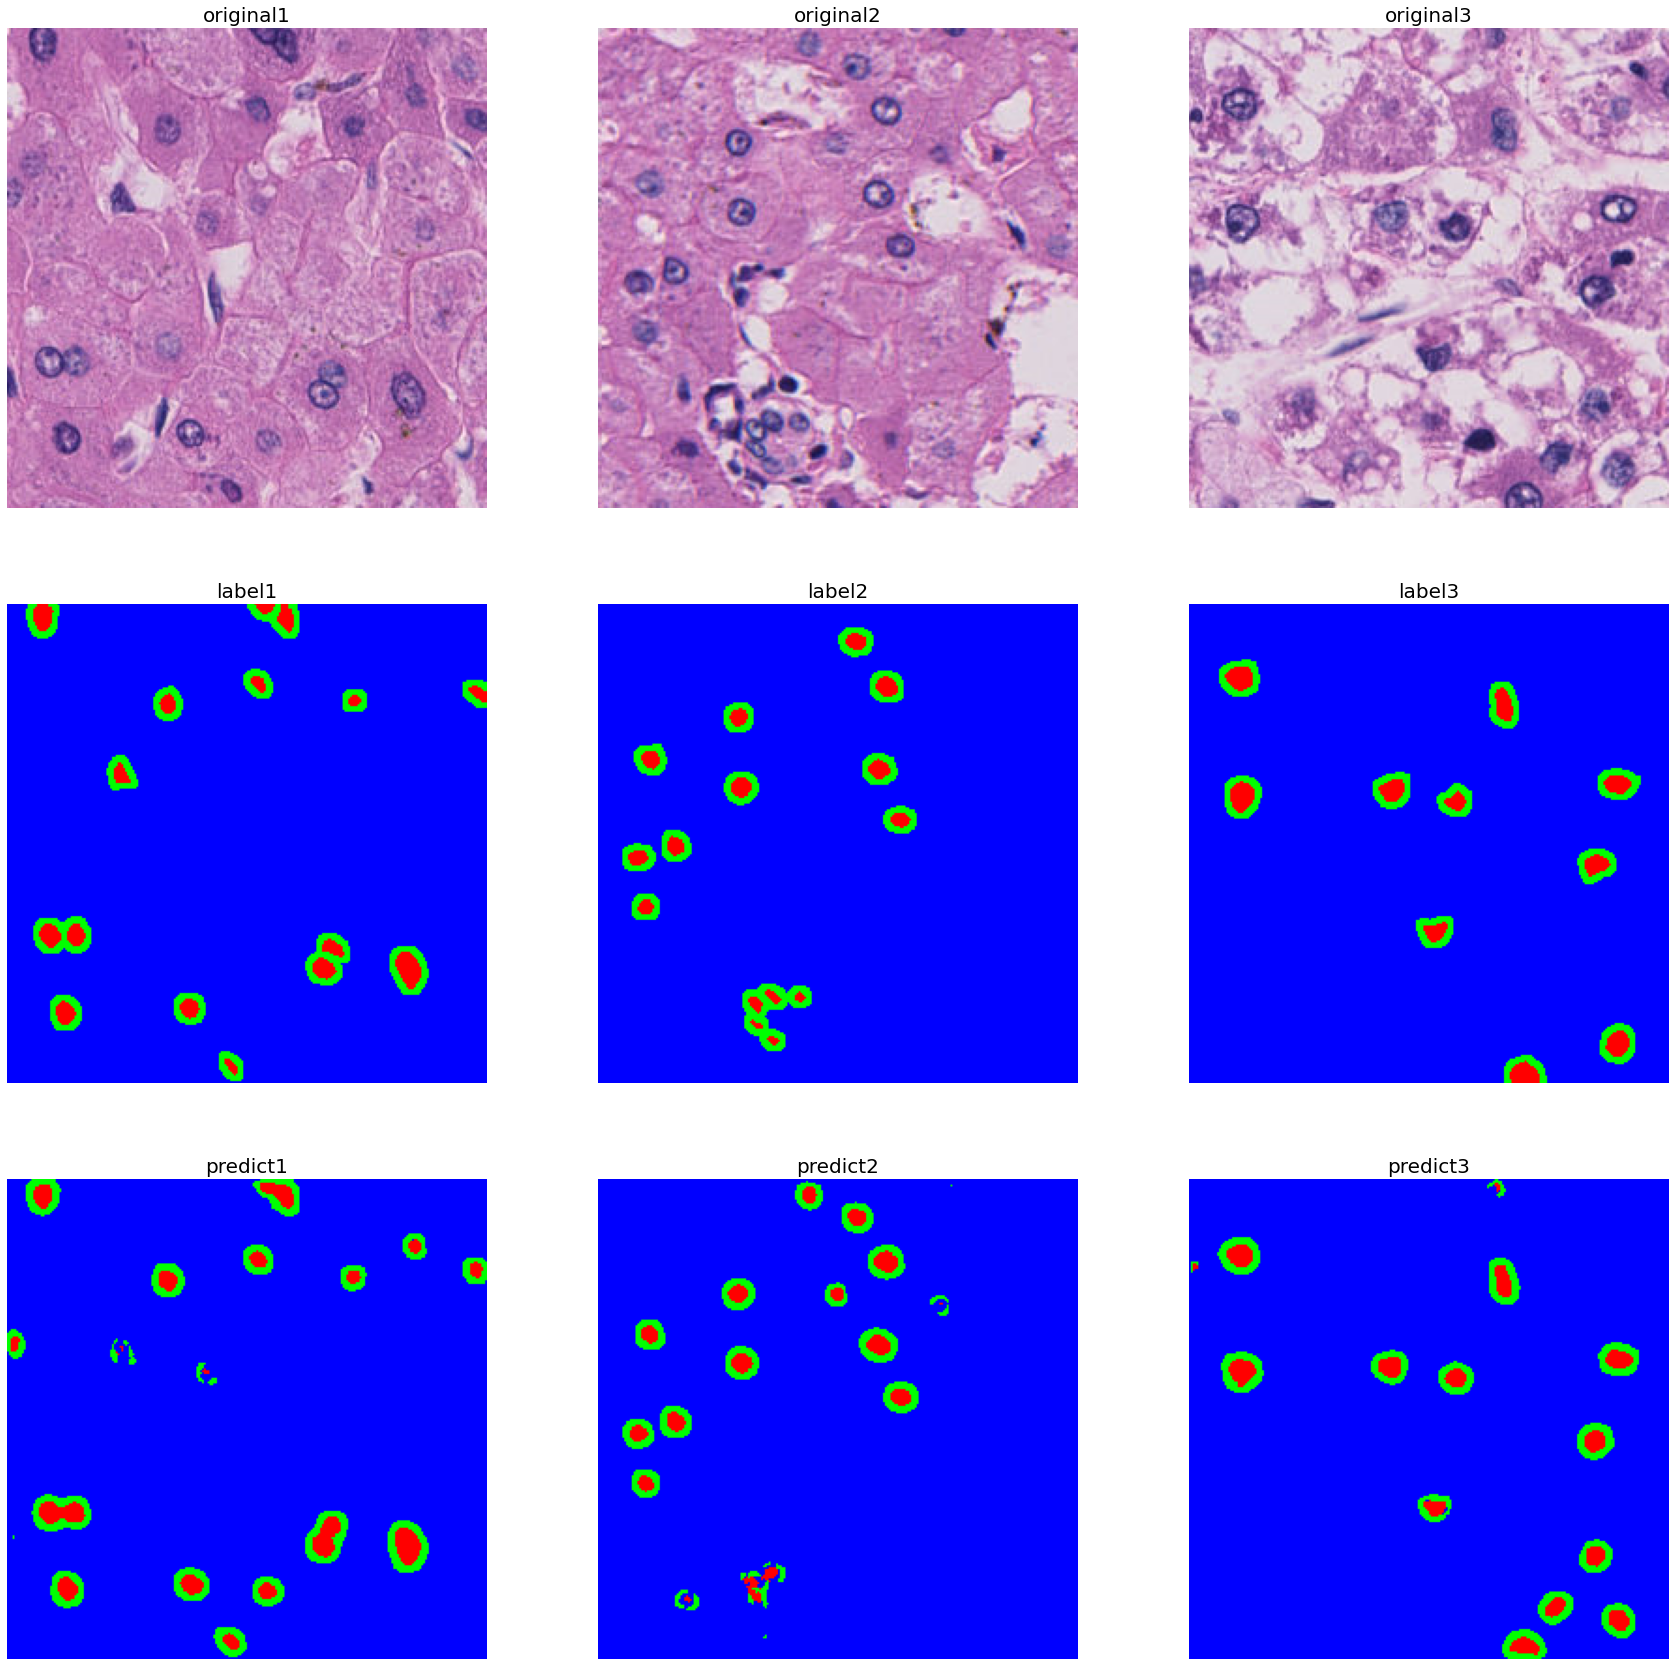

In [9]:
predict_list = sorted(glob.glob("sample/predict/*"))

fig, axs = plt.subplots(3, 3, figsize=(30,30))
sampling = random.sample(range(len(test_image_list)), k=3)
for col, i in enumerate(sampling):
    img = cv2.imread(test_image_list[i])
    label = cv2.imread(test_label_list[i])
    predict = cv2.imread(predict_list[i])
    axs[0, col].set_title("original{}".format(col+1), fontsize=20)
    axs[0, col].axis("off")
    axs[0, col].imshow(img[:,:,::-1])
    axs[1, col].set_title("label{}".format(col+1), fontsize=20)
    axs[1, col].axis("off")
    axs[1, col].imshow(label[:,:,::-1])
    axs[2, col].set_title("predict{}".format(col+1), fontsize=20)
    axs[2, col].axis("off")
    axs[2, col].imshow(predict[:,:,::-1])

## Postprocess and calculate nucleus features

In [10]:
def remove_edge_nuclei(cnt, image_h, image_w):
    for point in cnt:
        x = point[0][0]
        y = point[0][1]
        if x==0 or y==0 or x==image_w-1 or y==image_h-1:
            return 0
    else:
        return 1
    
def postprocess(img_path, label_path, dilations=2):
    img = cv2.imread(img_path)
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img_gray.shape[:2]
    img_label = cv2.imread(label_path)
    # get nuclei channel (red region) and binarize
    img_label = img_label[:,:,2]
    img_label[img_label>128] = 255
    img_label[img_label!=255] = 0

    contours, hierarchy = cv2.findContours(img_label, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    d = {}
    # Process the detected nuclei one by one.
    for index, cnt in enumerate(contours):
        black = np.zeros_like(img_gray,np.uint8)
        # remove nuclei detected on the edge of the image.
        if remove_edge_nuclei(cnt, h, w)==1 and len(cnt)>1: 
            img_each = cv2.drawContours(black, cnt , -1, 255, -1)
            # Contour (green area) completion processing by dilation.
            # This is not a strict completion and there is room for improvement.
            # The reason why this dilation is not done collectively (before for loop) is 
            # to prevent the cell nucleus region from being connected.
            kernel = np.ones((3,3),np.uint8)
            img_each = cv2.dilate(img_each, kernel, iterations = dilations)
            
            c, _ = cv2.findContours(img_each, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            img = cv2.drawContours(img, c ,-1 , (0, 255, 0), 2)
            img = cv2.putText(img, str(index), tuple(c[0][0][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            
            gray_each = img_gray.copy()
            gray_each = cv2.bitwise_and(gray_each, img_each)
            
            area = cv2.contourArea(c[0])
            if area==0:
                print("Warning : contain area==0")
            peri = cv2.arcLength(c[0], True)
            # The ratio of the perimeter of a perfect circle with the same area to the perimeter of the nucleus.
            circ = 2*np.sqrt(np.pi*area)/peri
            try:
                ellipse = cv2.fitEllipse(c[0])
                feature = {"area": area,
                           "perimeter": peri,
                           "circlarity":circ,
                           "semi-major axis": ellipse[1][1],
                           "semi-minor axis": ellipse[1][0],
                           "ellipticity": ellipse[1][0]/ellipse[1][1]}
            except:
                feature = {"area": area,
                           "perimeter": peri,
                           "circlarity":circ}
                print("Warning : impossible to calculate ellipse")
                
            # GLCM feature
            matrix_coocurrence = greycomatrix(gray_each, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], normed=False, symmetric=False)

            texture_contrast = greycoprops(matrix_coocurrence, 'contrast')
            texture_dissimilarity = greycoprops(matrix_coocurrence, 'dissimilarity')
            texture_homogeneity = greycoprops(matrix_coocurrence, 'homogeneity')
            texture_ASM = greycoprops(matrix_coocurrence, 'ASM')

            texture = {"texture_contrast": texture_contrast,
                       "texture_dissimilarity": texture_dissimilarity,
                       "texture_homogeneity": texture_homogeneity,
                       "texture_ASM": texture_ASM}
        d[index] = {"feature": feature, "texture": texture}

    return img, d

{0: {'feature': {'area': 166.5, 'perimeter': 49.55634891986847, 'circlarity': 0.9230234800569722, 'semi-major axis': 17.25371551513672, 'semi-minor axis': 12.587718963623047, 'ellipticity': 0.7295656957239046}, 'texture': {'texture_contrast': array([[ 8.49776348, 11.81042676,  9.02351409, 13.16701269]]), 'texture_dissimilarity': array([[0.1033701 , 0.1387005 , 0.10292586, 0.140792  ]]), 'texture_homogeneity': array([[0.99704879, 0.99692647, 0.99715378, 0.99693056]]), 'texture_ASM': array([[0.99388198, 0.99370473, 0.99391253, 0.99367407]])}}, 1: {'feature': {'area': 129.0, 'perimeter': 42.14213538169861, 'circlarity': 0.9553956272300749, 'semi-major axis': 14.215633392333984, 'semi-minor axis': 11.702919960021973, 'ellipticity': 0.823242949296439}, 'texture': {'texture_contrast': array([[6.78014706, 9.17440984, 6.28716299, 9.99594002]]), 'texture_dissimilarity': array([[0.07227328, 0.09540946, 0.06795343, 0.10306805]]), 'texture_homogeneity': array([[0.9977371 , 0.99759891, 0.99768044, 

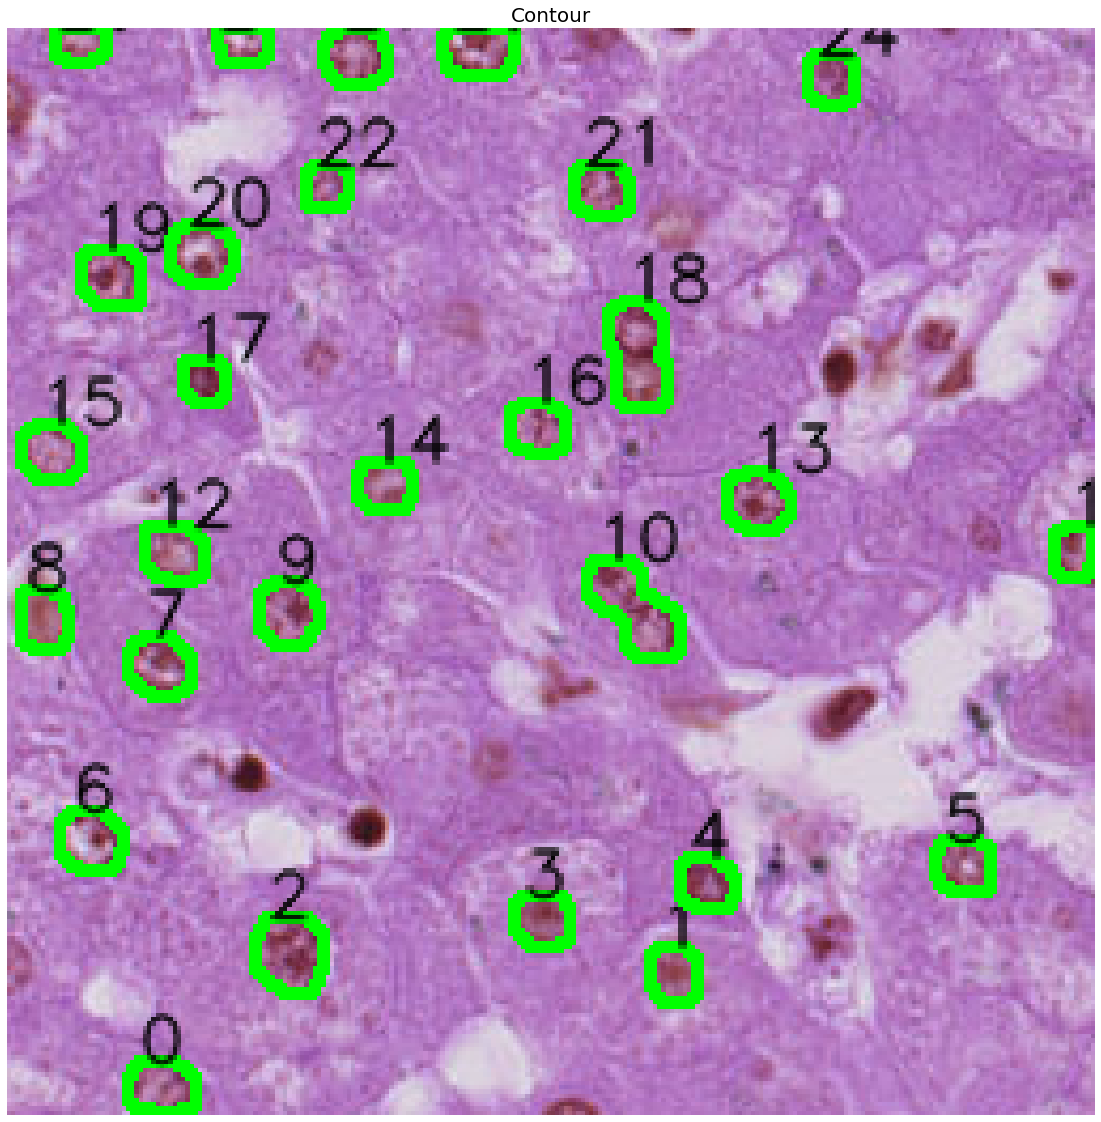

In [11]:
sampling = random.sample(range(len(test_image_list)), k=1)
draw_contour, d = postprocess(test_image_list[sampling[0]], predict_list[sampling[0]])
plt.figure(figsize=(20, 20))
plt.title("Contour", fontsize=20)
plt.axis("off")
plt.imshow(draw_contour)
print(d)